<a href="https://colab.research.google.com/github/Sujoy-004/Chat-Analyzer-Pro/blob/main/notebooks/05_network_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell 1: Setup Environment and Import Network Graph Module

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta
import warnings
import json
warnings.filterwarnings('ignore')

In [37]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [38]:
# Import the network_graph module from GitHub
import urllib.request
import sys

module_url = "https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/src/analysis/network_graph.py"

In [39]:
try:
    # Download and execute the module
    with urllib.request.urlopen(module_url) as response:
        module_code = response.read().decode('utf-8')

    # Create a module namespace
    network_module = {}
    exec(module_code, network_module)

    # Extract functions
    build_interaction_network = network_module['build_interaction_network']
    calculate_network_metrics = network_module['calculate_network_metrics']
    identify_key_participants = network_module['identify_key_participants']
    analyze_interaction_patterns = network_module['analyze_interaction_patterns']
    detect_subgroups = network_module['detect_subgroups']
    plot_network_graph = network_module['plot_network_graph']
    plot_network_dashboard = network_module['plot_network_dashboard']
    analyze_network = network_module['analyze_network']

    print("\nNetwork analysis module loaded successfully from GitHub")
    print("Functions imported:")
    print("  - build_interaction_network()")
    print("  - calculate_network_metrics()")
    print("  - identify_key_participants()")
    print("  - analyze_interaction_patterns()")
    print("  - detect_subgroups()")
    print("  - plot_network_graph()")
    print("  - plot_network_dashboard()")
    print("  - analyze_network() - Complete pipeline")

except Exception as e:
    print(f"\nError loading module: {e}")
    print("Please ensure the module is uploaded to GitHub at the correct path.")
    sys.exit(1)


Network analysis module loaded successfully from GitHub
Functions imported:
  - build_interaction_network()
  - calculate_network_metrics()
  - identify_key_participants()
  - analyze_interaction_patterns()
  - detect_subgroups()
  - plot_network_graph()
  - plot_network_dashboard()
  - analyze_network() - Complete pipeline


In [40]:
# Load Telegram group chat data (JSON format)
telegram_url = "https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/sample_chats/telegram_sample.json"

print(f"\nLoading Telegram group chat data...")

with urllib.request.urlopen(telegram_url) as response:
    telegram_data = json.loads(response.read().decode('utf-8'))


Loading Telegram group chat data...


In [41]:
# Parse Telegram JSON into DataFrame
messages = []
for msg in telegram_data['messages']:
    messages.append({
        'datetime': pd.to_datetime(msg['date']),
        'sender': msg['from'],
        'message': msg['text'],
        'message_id': msg['id']
    })

In [42]:
df = pd.DataFrame(messages)
df = df.sort_values('datetime').reset_index(drop=True)

# Add message length
df['message_length'] = df['message'].str.len()

print(f"\nDataset loaded: {len(df)} messages")
print(f"Date range: {df['datetime'].min().date()} to {df['datetime'].max().date()}")
print(f"Participants: {df['sender'].nunique()} ({', '.join(df['sender'].unique())})")


Dataset loaded: 5 messages
Date range: 2025-09-15 to 2025-09-15
Participants: 3 (Sujoy, Ravi, Ananya)


In [43]:
# Show message distribution
print(f"\nMessage distribution:")
for sender, count in df['sender'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  {sender}: {count} messages ({percentage:.1f}%)")


Message distribution:
  Sujoy: 2 messages (40.0%)
  Ravi: 2 messages (40.0%)
  Ananya: 1 messages (20.0%)


In [44]:
# Check if group chat
if df['sender'].nunique() >= 3:
    print(f"\nGroup chat confirmed with {df['sender'].nunique()} participants")
    print("Network analysis will show interaction patterns between all members")
else:
    print(f"\nNote: Only {df['sender'].nunique()} participants found")
    print("Network graphs work best with 3+ participants")


Group chat confirmed with 3 participants
Network analysis will show interaction patterns between all members


## Cell 2: Build Interaction Network and Calculate Metrics

In [45]:
# Build the directed interaction network
G = build_interaction_network(df, weight_threshold=0)

print(f"\nNetwork created:")
print(f"  Nodes (participants): {G.number_of_nodes()}")
print(f"  Edges (interactions): {G.number_of_edges()}")


Network created:
  Nodes (participants): 3
  Edges (interactions): 3


In [46]:
# Show all edges with weights
print(f"\nInteraction edges (who responds to whom):")
edge_weights = nx.get_edge_attributes(G, 'weight')

if edge_weights:
    for (from_node, to_node), weight in sorted(edge_weights.items(), key=lambda x: x[1], reverse=True):
        print(f"  {from_node} -> {to_node}: {weight} interactions")
else:
    print("  No interactions found")


Interaction edges (who responds to whom):
  Sujoy -> Ravi: 2 interactions
  Ravi -> Ananya: 1 interactions
  Ananya -> Sujoy: 1 interactions


In [47]:
# Calculate network metrics
metrics = calculate_network_metrics(G)

print(f"\nBasic properties:")
print(f"  Network density: {metrics['density']:.3f}")
print(f"  (Ratio of actual edges to possible edges)")
print(f"  Strongly connected: {metrics['is_strongly_connected']}")
print(f"  Weakly connected: {metrics['is_weakly_connected']}")


Basic properties:
  Network density: 0.500
  (Ratio of actual edges to possible edges)
  Strongly connected: True
  Weakly connected: True


In [48]:
if metrics['diameter']:
    print(f"  Network diameter: {metrics['diameter']}")
    print(f"  (Longest shortest path between any two nodes)")

  Network diameter: 1
  (Longest shortest path between any two nodes)


In [49]:
# Centrality measures
if 'degree_centrality' in metrics and metrics['degree_centrality']:
    print(f"\nDegree Centrality (overall connectivity):")
    for person, score in sorted(metrics['degree_centrality'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {person}: {score:.3f}")

if 'in_degree_centrality' in metrics and metrics['in_degree_centrality']:
    print(f"\nIn-Degree Centrality (receives responses):")
    for person, score in sorted(metrics['in_degree_centrality'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {person}: {score:.3f}")

if 'out_degree_centrality' in metrics and metrics['out_degree_centrality']:
    print(f"\nOut-Degree Centrality (sends responses):")
    for person, score in sorted(metrics['out_degree_centrality'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {person}: {score:.3f}")

if 'pagerank' in metrics and metrics['pagerank']:
    print(f"\nPageRank (influence score):")
    for person, score in sorted(metrics['pagerank'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {person}: {score:.3f}")


Degree Centrality (overall connectivity):
  Sujoy: 1.000
  Ravi: 1.000
  Ananya: 1.000

In-Degree Centrality (receives responses):
  Sujoy: 0.500
  Ravi: 0.500
  Ananya: 0.500

Out-Degree Centrality (sends responses):
  Sujoy: 0.500
  Ravi: 0.500
  Ananya: 0.500

PageRank (influence score):
  Sujoy: 0.333
  Ravi: 0.333
  Ananya: 0.333


## Cell 3: Identify Key Participants and Analyze Interaction Patterns


In [50]:
# Identify key participants based on network position
key_participants = identify_key_participants(G, metrics)

if 'most_active' in key_participants:
    print(f"\nMost Active (highest out-degree):")
    print(f"  {key_participants['most_active']['participant']}")
    print(f"  Score: {key_participants['most_active']['score']:.3f}")

if 'most_responsive' in key_participants:
    print(f"\nMost Responsive (highest in-degree):")
    print(f"  {key_participants['most_responsive']['participant']}")
    print(f"  Score: {key_participants['most_responsive']['score']:.3f}")

if 'most_influential' in key_participants:
    print(f"\nMost Influential (highest PageRank):")
    print(f"  {key_participants['most_influential']['participant']}")
    print(f"  Score: {key_participants['most_influential']['score']:.3f}")

if 'bridge_connector' in key_participants:
    print(f"\nBridge Connector (highest betweenness):")
    print(f"  {key_participants['bridge_connector']['participant']}")
    print(f"  Score: {key_participants['bridge_connector']['score']:.3f}")


Most Active (highest out-degree):
  Sujoy
  Score: 0.500

Most Responsive (highest in-degree):
  Sujoy
  Score: 0.500

Most Influential (highest PageRank):
  Sujoy
  Score: 0.333

Bridge Connector (highest betweenness):
  Sujoy
  Score: 0.500


In [51]:
patterns = analyze_interaction_patterns(df, G)

if 'strongest_connections' in patterns:
    print(f"\nStrongest connections:")
    for i, conn in enumerate(patterns['strongest_connections'][:5], 1):
        print(f"  {i}. {conn['from']} -> {conn['to']}: {conn['interactions']} interactions")

if 'reciprocal_interactions' in patterns:
    print(f"\nReciprocal interactions (mutual responses):")
    if patterns['reciprocal_interactions']:
        for recip in patterns['reciprocal_interactions']:
            person1, person2 = recip['pair']
            balance = recip['balance']
            balance_status = "balanced" if balance < 0.3 else "moderately balanced" if balance < 0.7 else "imbalanced"
            print(f"  {person1} <-> {person2}: {recip['forward']} vs {recip['backward']} ({balance_status})")
    else:
        print("  No reciprocal interactions found")

if 'reciprocity_score' in patterns:
    print(f"\nOverall reciprocity score: {patterns['reciprocity_score']:.2%}")
    print(f"  (Percentage of balanced mutual interactions)")

if 'interaction_matrix' in patterns:
    print(f"\nInteraction Matrix:")
    print(patterns['interaction_matrix'])


Strongest connections:
  1. Sujoy -> Ravi: 2 interactions
  2. Ravi -> Ananya: 1 interactions
  3. Ananya -> Sujoy: 1 interactions

Reciprocal interactions (mutual responses):
  No reciprocal interactions found

Overall reciprocity score: 0.00%
  (Percentage of balanced mutual interactions)

Interaction Matrix:
        Sujoy  Ravi  Ananya
Sujoy       0     2       0
Ravi        0     0       1
Ananya      1     0       0


## Cell 4: Detect Subgroups and Visualize Network


In [52]:
# Detect subgroups in the network
subgroups = detect_subgroups(G)

print(f"\nCommunity detection results:")
print(f"  Number of communities: {subgroups['num_communities']}")

if subgroups['modularity'] is not None:
    print(f"  Modularity score: {subgroups['modularity']:.3f}")
    print(f"  (Higher modularity = stronger community structure)")


Community detection results:
  Number of communities: 1
  Modularity score: 0.000
  (Higher modularity = stronger community structure)


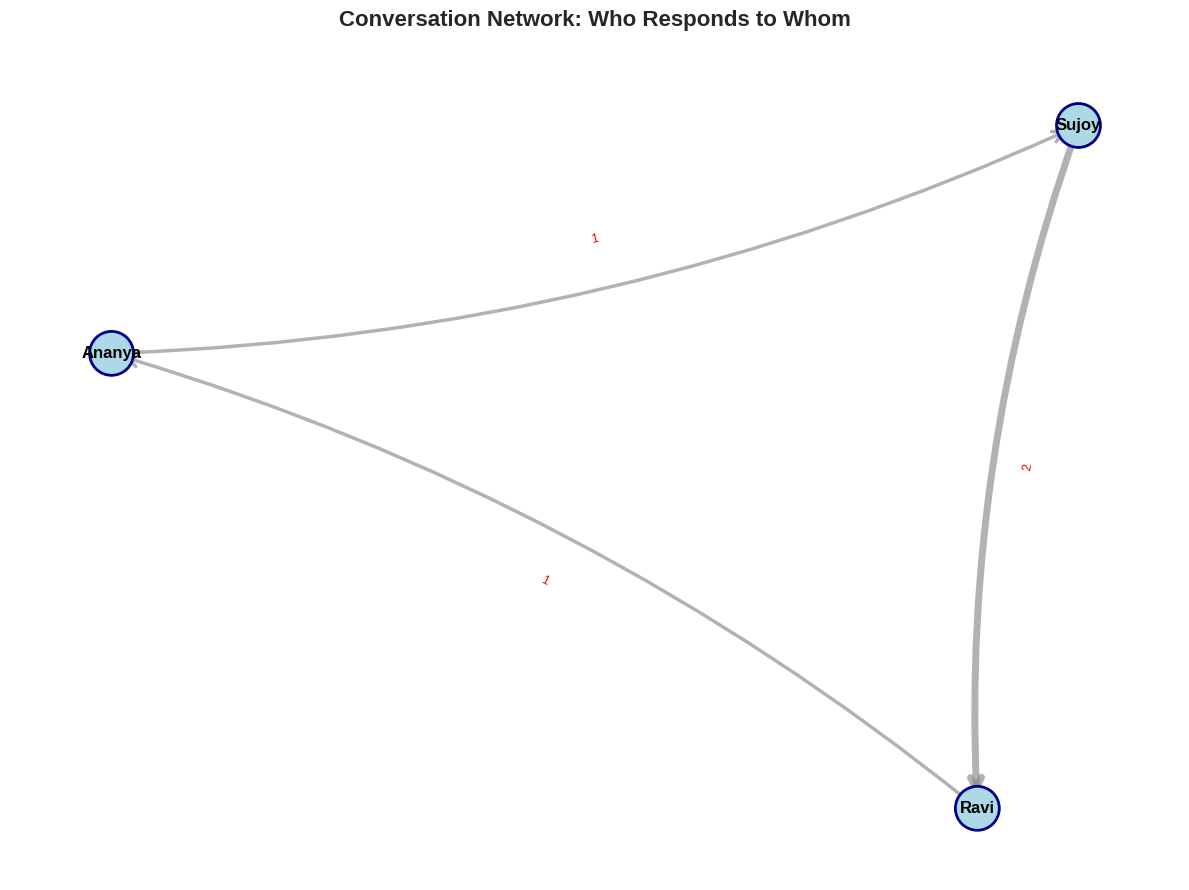

In [53]:
# Create network visualization with spring layout
plot_network_graph(
    G,
    metrics=metrics,
    layout='spring',
    figsize=(12, 9),
    node_size_metric='degree',
    title='Conversation Network: Who Responds to Whom'
)

## Cell 5: Create Comprehensive Network Analysis Dashboard

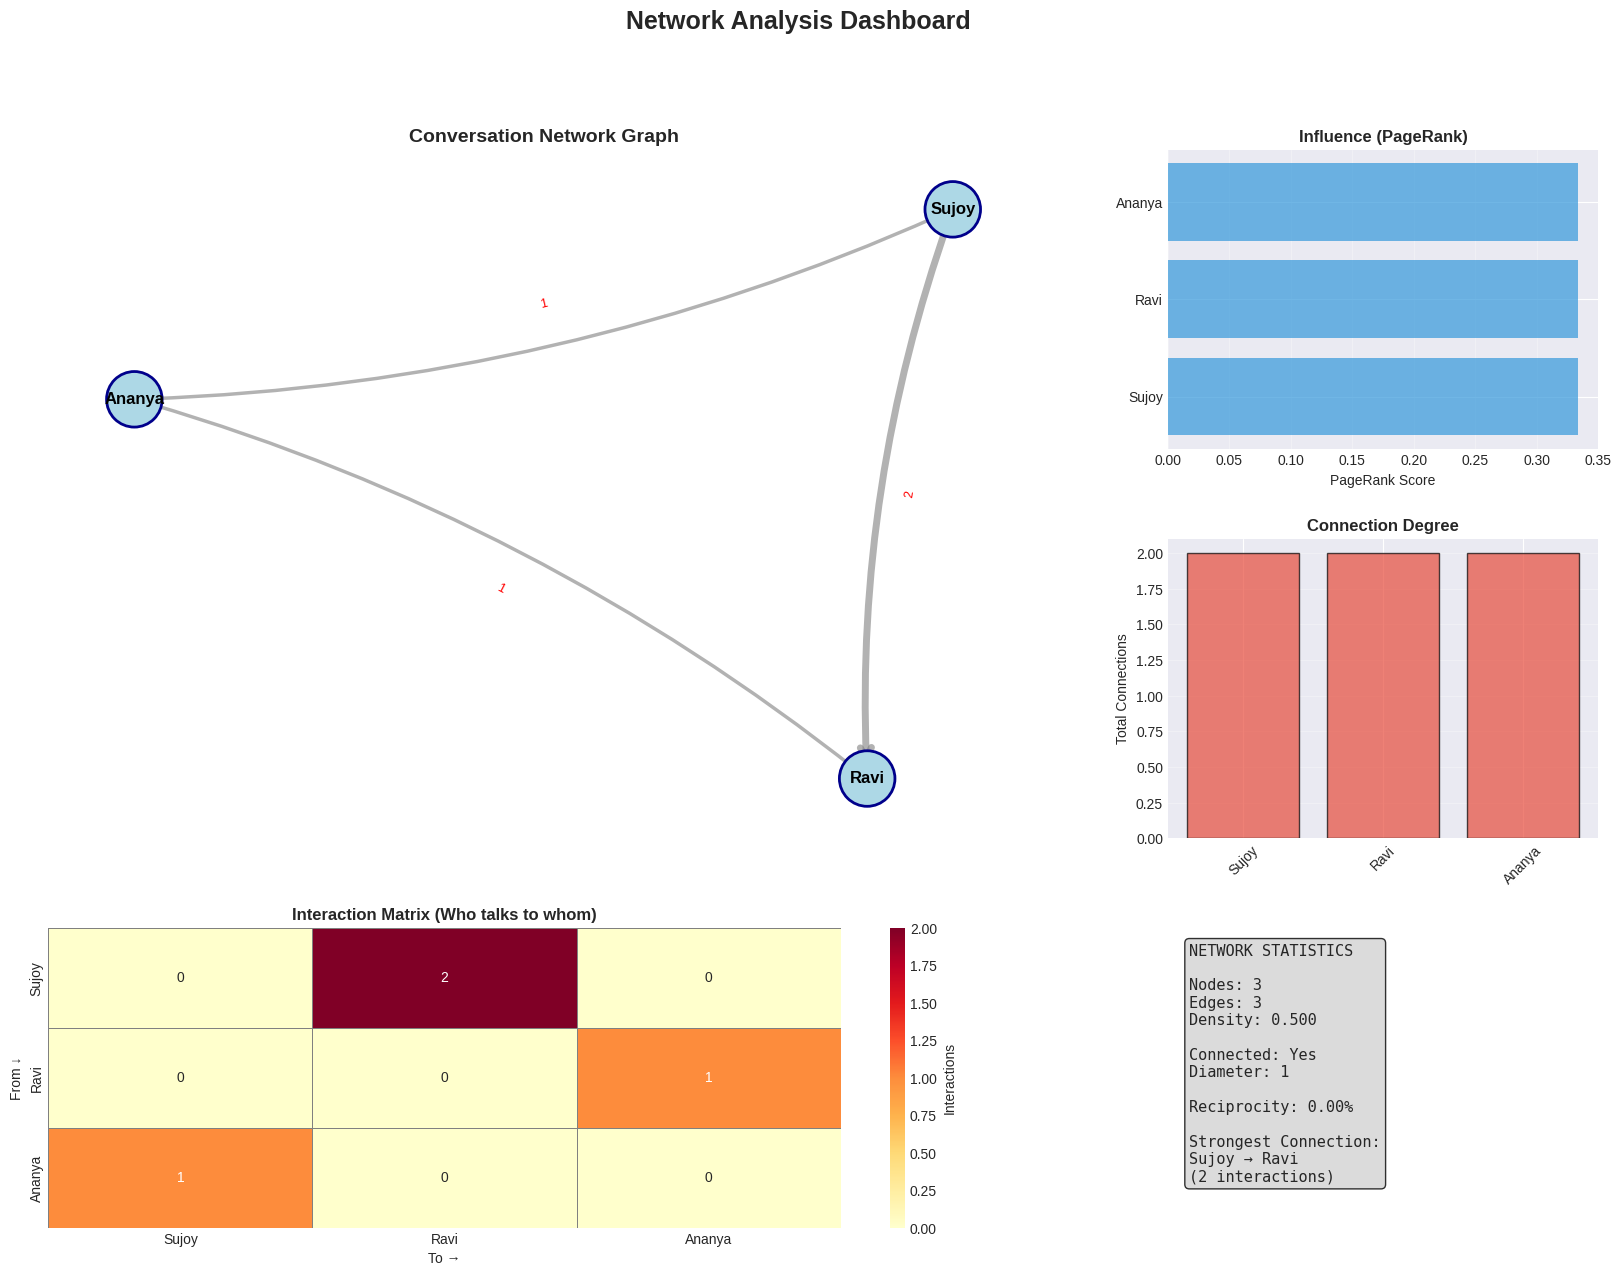


Comprehensive dashboard displayed with:
  1. Main network graph (top left)
  2. PageRank influence scores (top right)
  3. Connection degree distribution (middle right)
  4. Interaction matrix heatmap (bottom)
  5. Network statistics summary (bottom right)


In [54]:
# Create comprehensive dashboard with all network visualizations
plot_network_dashboard(
    G,
    metrics,
    patterns,
    figsize=(20, 14)
)

print("\nComprehensive dashboard displayed with:")
print("  1. Main network graph (top left)")
print("  2. PageRank influence scores (top right)")
print("  3. Connection degree distribution (middle right)")
print("  4. Interaction matrix heatmap (bottom)")
print("  5. Network statistics summary (bottom right)")

In [55]:
# Network structure
if metrics['density'] > 0.6:
    density_status = "highly connected"
elif metrics['density'] > 0.3:
    density_status = "moderately connected"
else:
    density_status = "sparsely connected"

print(f"  - Network is {density_status} (density: {metrics['density']:.2%})")

  - Network is moderately connected (density: 50.00%)


In [56]:
# Key participant
if key_participants:
    most_central = key_participants.get('most_influential', {}).get('participant', 'Unknown')
    print(f"  - Most influential participant: {most_central}")

  - Most influential participant: Sujoy


In [57]:
# Reciprocity
if patterns.get('reciprocity_score', 0) > 0.5:
    recip_status = "high reciprocity - balanced mutual interactions"
elif patterns.get('reciprocity_score', 0) > 0.2:
    recip_status = "moderate reciprocity - some mutual interactions"
else:
    recip_status = "low reciprocity - mostly one-way interactions"

print(f"  - Interaction pattern: {recip_status}")

  - Interaction pattern: low reciprocity - mostly one-way interactions


In [58]:
# Community structure
if subgroups['num_communities'] == 1:
    print(f"  - Single cohesive group with no subgroups detected")
else:
    print(f"  - {subgroups['num_communities']} distinct communities/subgroups found")

  - Single cohesive group with no subgroups detected


In [59]:
# Strongest connection
if patterns.get('strongest_connections'):
    top = patterns['strongest_connections'][0]
    print(f"  - Strongest connection: {top['from']} -> {top['to']} ({top['interactions']} interactions)")

  - Strongest connection: Sujoy -> Ravi (2 interactions)


## Cell 6: Complete Pipeline Analysis and Summary

In [60]:
# Run the complete analysis using the wrapper function
results = analyze_network(df, weight_threshold=0)

print("\nComplete analysis executed successfully")
print("\nResults structure:")
print(f"  - graph: NetworkX DiGraph with {results['graph'].number_of_nodes()} nodes, {results['graph'].number_of_edges()} edges")
print(f"  - metrics: {len(results['metrics'])} network metrics calculated")
print(f"  - key_participants: {len(results['key_participants'])} key roles identified")
print(f"  - patterns: Interaction analysis complete")
print(f"  - subgroups: {results['subgroups']['num_communities']} communities detected")


Complete analysis executed successfully

Results structure:
  - graph: NetworkX DiGraph with 3 nodes, 3 edges
  - metrics: 11 network metrics calculated
  - key_participants: 4 key roles identified
  - patterns: Interaction analysis complete
  - subgroups: 1 communities detected


In [61]:
print(f"\nNetwork Overview:")
print(f"  Participants: {results['metrics']['num_nodes']}")
print(f"  Total interactions: {results['metrics']['num_edges']}")
print(f"  Network density: {results['metrics']['density']:.2%}")
print(f"  Connectivity: {'Strongly connected' if results['metrics']['is_strongly_connected'] else 'Weakly connected' if results['metrics']['is_weakly_connected'] else 'Disconnected'}")


Network Overview:
  Participants: 3
  Total interactions: 3
  Network density: 50.00%
  Connectivity: Strongly connected


In [62]:
print(f"\nKey Roles:")
for role, data in results['key_participants'].items():
    role_name = role.replace('_', ' ').title()
    print(f"  {role_name}: {data['participant']} (score: {data['score']:.3f})")


Key Roles:
  Most Active: Sujoy (score: 0.500)
  Most Responsive: Sujoy (score: 0.500)
  Most Influential: Sujoy (score: 0.333)
  Bridge Connector: Sujoy (score: 0.500)


In [63]:
print(f"\nInteraction Patterns:")
print(f"  Reciprocity: {results['patterns']['reciprocity_score']:.1%}")
print(f"  Strongest link: {results['patterns']['strongest_connections'][0]['from']} -> {results['patterns']['strongest_connections'][0]['to']}")

print(f"\nCommunity Structure:")
print(f"  Communities: {results['subgroups']['num_communities']}")
if results['subgroups']['modularity'] is not None:
    print(f"  Modularity: {results['subgroups']['modularity']:.3f}")


Interaction Patterns:
  Reciprocity: 0.0%
  Strongest link: Sujoy -> Ravi

Community Structure:
  Communities: 1
  Modularity: 0.000
